In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sympy as sp
import random
import openpyxl
import pandas as pd
from sympy.plotting import plot3d
from IPython.display import display
from sympy import Symbol
import scipy.io
from mat4py import loadmat
import keras
from keras.callbacks import History,EarlyStopping
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.layers.recurrent import GRU
from keras.layers import Bidirectional
from sklearn.model_selection import train_test_split
from keras.models import load_model
from keras.optimizers import RMSprop, Adam
from keras.layers import Reshape
import time
from keras.models import load_model

Using TensorFlow backend.
D:\Users\Ray Lee\anaconda3\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Users\Ray Lee\anaconda3\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Users\Ray Lee\anaconda3\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Users\Ray Lee\anaconda3\envs\tf1\lib\site-pa

In [2]:
start = time.time()
Results_cross = []

def findAllFile_cross(base):
    for root, ds, fs in os.walk(base):
        for f in fs:
            if f.endswith('.mat'):
                fullname = os.path.join(root, f)
                mat = loadmat(fullname) 
                Results_cross.append(mat)
                yield fullname

#build temp list for crossing
IKlist = []
IAlist = []
GVlist = []
EPlist = []
EP_OBSlist = []
AP_01list = []
AP_02list = []
AP_03list = []
AP_04list = []
AP_05list = []
AP_06list = []


AP_01_array = np.empty((1,101))
AP_02_array = np.empty((1,101))
AP_03_array = np.empty((1,101))
AP_04_array = np.empty((1,101))
AP_05_array = np.empty((1,101))
AP_06_array = np.empty((1,101))

IK_array = np.empty((6,101,3))
IK_tay = np.empty((3,101))
IK_toay = np.empty((6,3,101))


IA_array = np.empty((4,101,1))
IA_tay = np.empty((1,101))
IA_toay = np.empty((4,1,101))

GV_array = np.empty((1,101,1))
GV_tay = np.empty((1,101))
GV_toay = np.empty((1,1,101))



Feature = np.empty((29,101))



def getfeature(value):
    
    
    #EP_array = np.empty((1))
    o = Results_cross[value]['Results']['EP']
    EPlist.append(o)
    
    EP_array = np.array(EPlist[value]['LeadingToeClearance'])
    Feature_obstacles1 = EP_array
    
    
    x = Results_cross[value]['Results']['IK']
    IKlist.append(x)
    
    IK_array[0,:,:] = np.array(IKlist[value]['LeadingAnkle'])
    IK_array[1,:,:] = np.array(IKlist[value]['LeadingHip'])
    IK_array[2,:,:] = np.array(IKlist[value]['LeadingKnee'])
    IK_array[3,:,:] = np.array(IKlist[value]['TrailingAnkle'])
    IK_array[4,:,:] = np.array(IKlist[value]['TrailingHip'])
    IK_array[5,:,:] = np.array(IKlist[value]['TrailingKnee'])
    
    
   
    for i in range(IK_toay.shape[0]):  
        IK_tay = np.transpose(IK_array[i])
        IK_toay[i,:,:] = IK_tay
   

    k = 0
    for i in range(IK_toay.shape[0]):
        for j in range(IK_toay.shape[1]):
            Feature[k,:] = IK_toay[i,j,:] #k = 3*i+j
            k += 1
    
    y = Results_cross[value]['Results']['IA']
    IAlist.append(y)
    IA_array[0,:,:] = np.array(IAlist[value]['FrontalIA'])
    IA_array[1,:,:] = np.array(IAlist[value]['FrontalRCIA'])
    IA_array[2,:,:] = np.array(IAlist[value]['SagittalIA'])
    IA_array[3,:,:] = np.array(IAlist[value]['SagittalRCIA'])
    
    for i in range(IA_array.shape[0]):
      IA_tay = np.transpose(IA_array[i])
      IA_toay[i,:,:] = IA_tay
      

    for i in range(IA_toay.shape[0]):
        for j in range(IA_toay.shape[1]):
            Feature[k,:] = IA_toay[i,j,:] #k = 3*i+j
            k += 1
    
    z = Results_cross[value]['Results']['SelfDefinedVariables']
    GVlist.append(z)
    GV_array[0,:,:] = np.array(GVlist[value]['GaitVelocity'])
    GV_tay = np.transpose(GV_array[0])
    GV_toay[0,:,:] = GV_tay
    Feature[22,:] = GV_toay[0,0,:]
    '''
    #從EP取出障礙物高度並與Clearance相加取得toe離地高度
    A = Results_cross[value]['Results']['EP']
    EP_OBSlist.append(A)
    
    EP_OBS_array = np.array(EP_OBSlist[value]['OBS']+EP_OBSlist[value]['LeadingToeClearance'])
    Feature_obstacles1 = EP_OBS_array
    '''
    
    #取出AP單一值資料並變成序列資料
    B = Results_cross[value]['Results']['AP']['BodyHeight']
    AP_01list.append(B)
    for i in range(101):
        AP_01_array[:,i] = np.array(AP_01list[value])
        Feature[23,:] = AP_01_array[:,i]
    
    C = Results_cross[value]['Results']['AP']['BW']
    AP_02list.append(C)
    for i in range(101):
        AP_02_array[:,i] = np.array(AP_02list[value])
        Feature[24,:] = AP_02_array[:,i]
    
    D = Results_cross[value]['Results']['AP']['FootLength']
    AP_03list.append(D)
    for i in range(101):
        AP_03_array[:,i] = np.array(AP_03list[value])
        Feature[25,:] = AP_03_array[:,i]
        
    E = Results_cross[value]['Results']['AP']['HipWidth']
    AP_04list.append(E)
    for i in range(101):
        AP_04_array[:,i] = np.array(AP_04list[value])
        Feature[26,:] = AP_04_array[:,i]
    
    F = Results_cross[value]['Results']['AP']['ShankLength']
    AP_05list.append(F)
    for i in range(101):
        AP_05_array[:,i] = np.array(AP_05list[value])
        Feature[27,:] = AP_05_array[:,i]
    
    G = Results_cross[value]['Results']['AP']['ThighLength']
    AP_06list.append(G)
    for i in range(101):
        AP_06_array[:,i] = np.array(AP_06list[value])
        Feature[28,:] = AP_06_array[:,i]
   
    
    
    
        
    return Feature,Feature_obstacles1

Feature_cross = np.empty((204,29,101))
Feature_obstacles = np.empty((204))
FEATUREccc = np.empty((29,101))



base = r"C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/"


for i in findAllFile_cross(base):
    print(i)



for i in range(len(Results_cross)):
    FEATUREccc,Feature_obs= getfeature(i)
    Feature_cross[i,:,:] = FEATUREccc
    Feature_obstacles[i] = Feature_obs

    
print(Feature_cross)

C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/E01\OC10\Trial40\Results.mat
C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/E01\OC10\Trial41\Results.mat
C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/E01\OC10\Trial49\Results.mat
C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/E01\OC10\Trial50\Results.mat
C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/E01\OC20\Trial100\Results.mat
C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/E01\OC20\Trial109\Results.mat
C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/E01\OC20\Trial110\Results.mat
C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/E01\OC20\Trial99\Results.mat
C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/E01\OC30\Trial113\Results.mat
C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/E01\OC30\Trial114\Results.mat
C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/E01\OC30\Trial116\Results.mat
C:/Users/Danny Lee/Desktop/motion hw/final/Resul

C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/E14\OC30\Trial92\Results.mat
C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/E14\OC30\Trial93\Results.mat
C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/E14\OC30\Trial95\Results.mat
C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/E14\OC30\Trial96\Results.mat
C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/E15\OC10\Trial36\Results.mat
C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/E15\OC10\Trial38\Results.mat
C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/E15\OC10\Trial39\Results.mat
C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/E15\OC10\Trial45\Results.mat
C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/E15\OC20\Trial59\Results.mat
C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/E15\OC20\Trial60\Results.mat
C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/E15\OC20\Trial65\Results.mat
C:/Users/Danny Lee/Desktop/motion hw/final/Results_cro

In [3]:
X_normalized = (Feature_cross - Feature_cross.mean()) / Feature_cross.std()
X_train, X_test, y_train, y_test = train_test_split(X_normalized, Feature_obstacles, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
#train=0.8，val=0.1，test=0.1

# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[2] , X_train.shape[1])
X_val =X_val.reshape(X_val.shape[0],X_val.shape[2] , X_val.shape[1])
X_test = X_test.reshape(X_test.shape[0],X_test.shape[2] , X_test.shape[1])

In [4]:
class SelfAttention(keras.layers.Layer):
        def __init__(self, attention_units):
            super(SelfAttention, self).__init__()
            self.attention_units = attention_units

        def build(self, input_shape):
            self.W = self.add_weight(
                shape=(input_shape[-1], self.attention_units),
                initializer="glorot_uniform",
                trainable=True
            )
            self.b = self.add_weight(
                shape=(self.attention_units,),
                initializer="zeros",
                trainable=True
            )
            self.V = self.add_weight(
                shape=(self.attention_units, 1),
                initializer="glorot_uniform",
                trainable=True
            )
    
        def call(self, inputs):
            score = keras.activations.tanh(keras.backend.dot(inputs, self.W) + self.b)
            attention_weights = keras.activations.softmax(keras.backend.dot(score, self.V), axis=1)
            attended_input = inputs * attention_weights
            return attended_input

In [5]:
#import tensorflow as tf
d = 0.01
model = Sequential()
input_shape=(101,29)
model.add(Bidirectional(GRU(64, input_shape=(101,29), return_sequences=False)))
model.add(Dropout(d))
model.add(SelfAttention(64))
model.add(Dense(32, activation='relu'))
model.add(SelfAttention(32))
model.add(Dense(32, activation='relu'))
model.add(SelfAttention(32))
model.add(Dense(16, activation='relu'))
model.add(SelfAttention(16))
model.add(Dense(16, activation='relu'))
model.add(SelfAttention(16))
model.add(Dense(8, activation='relu'))
model.add(SelfAttention(8))
model.add(Dense(8, activation='relu'))
model.add(SelfAttention(8))
model.add(Dense(4, activation='relu'))
model.add(SelfAttention(4))
model.add(Dense(4, activation='relu'))
model.add(SelfAttention(4))
model.add(Dense(2, activation='relu'))
model.add(SelfAttention(2))
model.add(Dense(2, activation='relu'))
model.add(SelfAttention(2))
model.add(Dense(1, activation='linear'))

#model = load_model('C:/Users/Danny Lee/Desktop/motion hw/final/LSTM model performance/try_best_nodropout/Regression.h5')
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer= opt)
start_fitting = time.time()
#model.load_weights('C:/Users/Danny Lee/Desktop/motion hw/final/LSTM model performance/try_best_nodropout/Regression_weights.h5'.encode('utf-8'))
#model = tf.keras.models.load_model('C:/Users/Danny Lee/Desktop/motion hw/final/LSTM model performance/try_best_nodropout/Regression_weights.h5')
model.fit(X_train, y_train, epochs=2000, batch_size=32,validation_data=(X_val, y_val))
fitting_model_time = time.time()
print('Training Model took: ', fitting_model_time - start_fitting)


Train on 164 samples, validate on 19 samples
Epoch 1/2000
164/164 [==============================] - 1s 8ms/step - loss: 35182.7440 - val_loss: 25099.5039
Epoch 2/2000
164/164 [==============================] - 0s 991us/step - loss: 35124.8436 - val_loss: 25036.5176
Epoch 3/2000
164/164 [==============================] - 0s 979us/step - loss: 35029.5104 - val_loss: 24924.6250
Epoch 4/2000
164/164 [==============================] - 0s 973us/step - loss: 34856.1557 - val_loss: 24705.5156
Epoch 5/2000
164/164 [==============================] - 0s 955us/step - loss: 34479.2935 - val_loss: 24157.0840
Epoch 6/2000
164/164 [==============================] - 0s 924us/step - loss: 33606.0151 - val_loss: 23192.7383
Epoch 7/2000
164/164 [==============================] - 0s 911us/step - loss: 32206.3219 - val_loss: 21649.4512
Epoch 8/2000
164/164 [==============================] - 0s 904us/step - loss: 29883.6297 - val_loss: 19105.1875
Epoch 9/2000
164/164 [==============================] - 0s 9

164/164 [==============================] - 0s 1ms/step - loss: 2908.9731 - val_loss: 5350.2695
Epoch 147/2000
164/164 [==============================] - 0s 1ms/step - loss: 2912.3579 - val_loss: 5243.8560
Epoch 148/2000
164/164 [==============================] - 0s 1ms/step - loss: 2898.9668 - val_loss: 4891.7251
Epoch 149/2000
164/164 [==============================] - 0s 1ms/step - loss: 2981.6211 - val_loss: 4544.6045
Epoch 150/2000
164/164 [==============================] - 0s 1ms/step - loss: 2964.8403 - val_loss: 5085.8901
Epoch 151/2000
164/164 [==============================] - 0s 1ms/step - loss: 2929.3135 - val_loss: 5483.7461
Epoch 152/2000
164/164 [==============================] - 0s 1ms/step - loss: 2954.4304 - val_loss: 5091.9312
Epoch 153/2000
164/164 [==============================] - 0s 1ms/step - loss: 2908.3066 - val_loss: 5252.3027
Epoch 154/2000
164/164 [==============================] - 0s 1ms/step - loss: 2887.8989 - val_loss: 5254.6455
Epoch 155/2000
164/164 [=

164/164 [==============================] - 0s 1ms/step - loss: 2920.2693 - val_loss: 5243.4399
Epoch 295/2000
164/164 [==============================] - 0s 1ms/step - loss: 2925.4593 - val_loss: 5458.4644
Epoch 296/2000
164/164 [==============================] - 0s 1ms/step - loss: 2918.2285 - val_loss: 5249.8921
Epoch 297/2000
164/164 [==============================] - 0s 1ms/step - loss: 2940.9349 - val_loss: 5255.4355
Epoch 298/2000
164/164 [==============================] - 0s 1ms/step - loss: 2923.9330 - val_loss: 5264.7070
Epoch 299/2000
164/164 [==============================] - 0s 1ms/step - loss: 2927.2973 - val_loss: 5118.4243
Epoch 300/2000
164/164 [==============================] - 0s 1ms/step - loss: 2935.9227 - val_loss: 5730.2056
Epoch 301/2000
164/164 [==============================] - 0s 1ms/step - loss: 2920.8247 - val_loss: 4922.8896
Epoch 302/2000
164/164 [==============================] - 0s 1ms/step - loss: 2931.0192 - val_loss: 4759.0249
Epoch 303/2000
164/164 [=

164/164 [==============================] - 0s 1ms/step - loss: 2950.9666 - val_loss: 5367.1470
Epoch 443/2000
164/164 [==============================] - 0s 1ms/step - loss: 2905.9137 - val_loss: 5139.4810
Epoch 444/2000
164/164 [==============================] - 0s 1ms/step - loss: 2871.0481 - val_loss: 5162.7920
Epoch 445/2000
164/164 [==============================] - 0s 1ms/step - loss: 2929.2375 - val_loss: 5034.2891
Epoch 446/2000
164/164 [==============================] - 0s 1ms/step - loss: 2921.1274 - val_loss: 5137.9663
Epoch 447/2000
164/164 [==============================] - 0s 1ms/step - loss: 2940.7641 - val_loss: 5406.6572
Epoch 448/2000
164/164 [==============================] - 0s 1ms/step - loss: 2875.9071 - val_loss: 5044.1836
Epoch 449/2000
164/164 [==============================] - 0s 1ms/step - loss: 2906.5430 - val_loss: 5094.4888
Epoch 450/2000
164/164 [==============================] - 0s 1ms/step - loss: 2894.7773 - val_loss: 5150.6479
Epoch 451/2000
164/164 [=

164/164 [==============================] - 0s 1ms/step - loss: 2915.9704 - val_loss: 4653.0664
Epoch 591/2000
164/164 [==============================] - 0s 1ms/step - loss: 2962.5214 - val_loss: 4950.3765
Epoch 592/2000
164/164 [==============================] - 0s 1ms/step - loss: 2915.2852 - val_loss: 5229.0723
Epoch 593/2000
164/164 [==============================] - 0s 1ms/step - loss: 2891.0291 - val_loss: 4817.7461
Epoch 594/2000
164/164 [==============================] - 0s 1ms/step - loss: 3031.0136 - val_loss: 4480.5645
Epoch 595/2000
164/164 [==============================] - 0s 1ms/step - loss: 2983.6126 - val_loss: 5226.9336
Epoch 596/2000
164/164 [==============================] - 0s 1ms/step - loss: 2886.9540 - val_loss: 5317.9497
Epoch 597/2000
164/164 [==============================] - 0s 1ms/step - loss: 2913.4535 - val_loss: 5521.3589
Epoch 598/2000
164/164 [==============================] - 0s 1ms/step - loss: 2965.1752 - val_loss: 5523.3765
Epoch 599/2000
164/164 [=

164/164 [==============================] - 0s 1ms/step - loss: 2964.4153 - val_loss: 4759.0879
Epoch 739/2000
164/164 [==============================] - 0s 1ms/step - loss: 2960.7808 - val_loss: 4910.5640
Epoch 740/2000
164/164 [==============================] - 0s 1ms/step - loss: 3008.2140 - val_loss: 5579.3760
Epoch 741/2000
164/164 [==============================] - 0s 1ms/step - loss: 2904.7212 - val_loss: 4902.3926
Epoch 742/2000
164/164 [==============================] - 0s 1ms/step - loss: 2908.5758 - val_loss: 4613.2178
Epoch 743/2000
164/164 [==============================] - 0s 1ms/step - loss: 2961.2540 - val_loss: 5148.1255
Epoch 744/2000
164/164 [==============================] - 0s 1ms/step - loss: 2893.3828 - val_loss: 5094.4937
Epoch 745/2000
164/164 [==============================] - 0s 1ms/step - loss: 2881.6442 - val_loss: 4731.0190
Epoch 746/2000
164/164 [==============================] - 0s 1ms/step - loss: 3034.1507 - val_loss: 4446.4180
Epoch 747/2000
164/164 [=

164/164 [==============================] - 0s 1ms/step - loss: 2946.5451 - val_loss: 5281.9619
Epoch 887/2000
164/164 [==============================] - 0s 1ms/step - loss: 3031.8341 - val_loss: 4594.8066
Epoch 888/2000
164/164 [==============================] - 0s 1ms/step - loss: 2973.9580 - val_loss: 5198.1836
Epoch 889/2000
164/164 [==============================] - 0s 1ms/step - loss: 2901.4081 - val_loss: 5499.0742
Epoch 890/2000
164/164 [==============================] - 0s 1ms/step - loss: 2918.6302 - val_loss: 5059.6509
Epoch 891/2000
164/164 [==============================] - 0s 1ms/step - loss: 2910.4251 - val_loss: 4934.0947
Epoch 892/2000
164/164 [==============================] - 0s 1ms/step - loss: 2915.0682 - val_loss: 4913.6504
Epoch 893/2000
164/164 [==============================] - 0s 1ms/step - loss: 2881.8249 - val_loss: 5273.4004
Epoch 894/2000
164/164 [==============================] - 0s 1ms/step - loss: 2924.6244 - val_loss: 5333.4150
Epoch 895/2000
164/164 [=

164/164 [==============================] - 0s 1ms/step - loss: 2927.6203 - val_loss: 5024.2754
Epoch 1035/2000
164/164 [==============================] - 0s 1ms/step - loss: 2895.3274 - val_loss: 5124.4175
Epoch 1036/2000
164/164 [==============================] - 0s 1ms/step - loss: 2949.9688 - val_loss: 5274.0562
Epoch 1037/2000
164/164 [==============================] - 0s 1ms/step - loss: 2875.0289 - val_loss: 4860.7271
Epoch 1038/2000
164/164 [==============================] - 0s 1ms/step - loss: 2943.2302 - val_loss: 5197.2959
Epoch 1039/2000
164/164 [==============================] - 0s 1ms/step - loss: 2930.0430 - val_loss: 5422.6587
Epoch 1040/2000
164/164 [==============================] - 0s 1ms/step - loss: 2894.3034 - val_loss: 5427.2876
Epoch 1041/2000
164/164 [==============================] - 0s 1ms/step - loss: 2907.0659 - val_loss: 5215.7925
Epoch 1042/2000
164/164 [==============================] - 0s 1ms/step - loss: 2904.2549 - val_loss: 5091.4956
Epoch 1043/2000
1

Epoch 1108/2000
164/164 [==============================] - 0s 1ms/step - loss: 2992.5311 - val_loss: 4620.8286
Epoch 1109/2000
164/164 [==============================] - 0s 1ms/step - loss: 2906.3274 - val_loss: 5160.8740
Epoch 1110/2000
164/164 [==============================] - 0s 1ms/step - loss: 2937.4417 - val_loss: 5745.3555
Epoch 1111/2000
164/164 [==============================] - 0s 1ms/step - loss: 2992.3328 - val_loss: 5598.7280
Epoch 1112/2000
164/164 [==============================] - 0s 1ms/step - loss: 3052.1780 - val_loss: 4836.9741
Epoch 1113/2000
164/164 [==============================] - 0s 1ms/step - loss: 2909.6841 - val_loss: 5139.3525
Epoch 1114/2000
164/164 [==============================] - 0s 1ms/step - loss: 2914.8363 - val_loss: 5967.3315
Epoch 1115/2000
164/164 [==============================] - 0s 1ms/step - loss: 3007.0062 - val_loss: 5439.1069
Epoch 1116/2000
164/164 [==============================] - 0s 1ms/step - loss: 2911.5976 - val_loss: 5125.2051
E

Epoch 1182/2000
164/164 [==============================] - 0s 1ms/step - loss: 2976.0473 - val_loss: 5350.6650
Epoch 1183/2000
164/164 [==============================] - 0s 1ms/step - loss: 2936.6474 - val_loss: 4751.6260
Epoch 1184/2000
164/164 [==============================] - 0s 1ms/step - loss: 2892.9756 - val_loss: 5289.0806
Epoch 1185/2000
164/164 [==============================] - 0s 1ms/step - loss: 2892.5362 - val_loss: 5089.9072
Epoch 1186/2000
164/164 [==============================] - 0s 1ms/step - loss: 2890.2417 - val_loss: 4869.0815
Epoch 1187/2000
164/164 [==============================] - 0s 1ms/step - loss: 2963.3928 - val_loss: 4621.3501
Epoch 1188/2000
164/164 [==============================] - 0s 1ms/step - loss: 2977.8033 - val_loss: 4763.8008
Epoch 1189/2000
164/164 [==============================] - 0s 1ms/step - loss: 2864.3544 - val_loss: 5693.5947
Epoch 1190/2000
164/164 [==============================] - 0s 1ms/step - loss: 2957.0007 - val_loss: 5475.9795
E

Epoch 1256/2000
164/164 [==============================] - 0s 1ms/step - loss: 2981.4971 - val_loss: 5083.1655
Epoch 1257/2000
164/164 [==============================] - 0s 1ms/step - loss: 2852.3775 - val_loss: 4647.4546
Epoch 1258/2000
164/164 [==============================] - 0s 1ms/step - loss: 2871.2841 - val_loss: 5330.2085
Epoch 1259/2000
164/164 [==============================] - 0s 1ms/step - loss: 2989.1969 - val_loss: 5602.8931
Epoch 1260/2000
164/164 [==============================] - 0s 1ms/step - loss: 2964.1391 - val_loss: 4632.7085
Epoch 1261/2000
164/164 [==============================] - 0s 1ms/step - loss: 2877.4199 - val_loss: 5076.3667
Epoch 1262/2000
164/164 [==============================] - 0s 1ms/step - loss: 2902.2639 - val_loss: 5331.5220
Epoch 1263/2000
164/164 [==============================] - 0s 1ms/step - loss: 2867.8502 - val_loss: 4782.7427
Epoch 1264/2000
164/164 [==============================] - 0s 1ms/step - loss: 2929.1802 - val_loss: 4687.5596
E

Epoch 1330/2000
164/164 [==============================] - 0s 1ms/step - loss: 2741.4626 - val_loss: 4311.9399
Epoch 1331/2000
164/164 [==============================] - 0s 1ms/step - loss: 2769.6837 - val_loss: 5029.3291
Epoch 1332/2000
164/164 [==============================] - 0s 1ms/step - loss: 2726.5650 - val_loss: 4302.8403
Epoch 1333/2000
164/164 [==============================] - 0s 1ms/step - loss: 2761.9177 - val_loss: 5094.5854
Epoch 1334/2000
164/164 [==============================] - 0s 1ms/step - loss: 2752.0700 - val_loss: 4427.5278
Epoch 1335/2000
164/164 [==============================] - 0s 1ms/step - loss: 2747.3267 - val_loss: 4321.7944
Epoch 1336/2000
164/164 [==============================] - 0s 1ms/step - loss: 2712.5158 - val_loss: 4876.3164
Epoch 1337/2000
164/164 [==============================] - 0s 1ms/step - loss: 2719.3936 - val_loss: 3889.9407
Epoch 1338/2000
164/164 [==============================] - 0s 1ms/step - loss: 2917.4942 - val_loss: 3989.2656
E

Epoch 1404/2000
164/164 [==============================] - 0s 1ms/step - loss: 1635.0558 - val_loss: 2917.1067
Epoch 1405/2000
164/164 [==============================] - 0s 1ms/step - loss: 1556.1527 - val_loss: 1556.8687
Epoch 1406/2000
164/164 [==============================] - 0s 1ms/step - loss: 1657.1650 - val_loss: 2707.9448
Epoch 1407/2000
164/164 [==============================] - 0s 1ms/step - loss: 1451.8342 - val_loss: 1852.8134
Epoch 1408/2000
164/164 [==============================] - 0s 1ms/step - loss: 1529.8435 - val_loss: 2702.9631
Epoch 1409/2000
164/164 [==============================] - 0s 1ms/step - loss: 1327.4586 - val_loss: 1977.2017
Epoch 1410/2000
164/164 [==============================] - 0s 1ms/step - loss: 1210.5121 - val_loss: 2374.7368
Epoch 1411/2000
164/164 [==============================] - 0s 1ms/step - loss: 1205.2891 - val_loss: 1913.2765
Epoch 1412/2000
164/164 [==============================] - 0s 1ms/step - loss: 1256.4391 - val_loss: 2350.7808
E

164/164 [==============================] - 0s 1ms/step - loss: 342.7615 - val_loss: 1926.0551
Epoch 1553/2000
164/164 [==============================] - 0s 1ms/step - loss: 305.3361 - val_loss: 1741.7906
Epoch 1554/2000
164/164 [==============================] - 0s 1ms/step - loss: 281.1913 - val_loss: 1902.8687
Epoch 1555/2000
164/164 [==============================] - 0s 1ms/step - loss: 225.8260 - val_loss: 2018.4907
Epoch 1556/2000
164/164 [==============================] - 0s 1ms/step - loss: 212.1307 - val_loss: 1942.6569
Epoch 1557/2000
164/164 [==============================] - 0s 1ms/step - loss: 197.1556 - val_loss: 1971.9679
Epoch 1558/2000
164/164 [==============================] - 0s 1ms/step - loss: 204.6823 - val_loss: 2484.9207
Epoch 1559/2000
164/164 [==============================] - 0s 1ms/step - loss: 198.9290 - val_loss: 2140.0867
Epoch 1560/2000
164/164 [==============================] - 0s 1ms/step - loss: 256.7912 - val_loss: 1771.1581
Epoch 1561/2000
164/164 [=

Epoch 1701/2000
164/164 [==============================] - 0s 1ms/step - loss: 58.1690 - val_loss: 2545.3770
Epoch 1702/2000
164/164 [==============================] - 0s 1ms/step - loss: 58.0098 - val_loss: 2449.2544
Epoch 1703/2000
164/164 [==============================] - 0s 1ms/step - loss: 78.3129 - val_loss: 2679.0830
Epoch 1704/2000
164/164 [==============================] - 0s 1ms/step - loss: 71.5552 - val_loss: 2570.9678
Epoch 1705/2000
164/164 [==============================] - 0s 1ms/step - loss: 57.9617 - val_loss: 2545.4133
Epoch 1706/2000
164/164 [==============================] - 0s 1ms/step - loss: 67.2725 - val_loss: 2467.3730
Epoch 1707/2000
164/164 [==============================] - 0s 1ms/step - loss: 86.1544 - val_loss: 2317.8335
Epoch 1708/2000
164/164 [==============================] - 0s 1ms/step - loss: 77.0264 - val_loss: 2803.6765
Epoch 1709/2000
164/164 [==============================] - 0s 1ms/step - loss: 72.9875 - val_loss: 2314.0981
Epoch 1710/2000
164

Epoch 1776/2000
164/164 [==============================] - 0s 1ms/step - loss: 41.1827 - val_loss: 2411.3701
Epoch 1777/2000
164/164 [==============================] - 0s 1ms/step - loss: 57.2128 - val_loss: 2414.5906
Epoch 1778/2000
164/164 [==============================] - 0s 1ms/step - loss: 49.6344 - val_loss: 2213.6567
Epoch 1779/2000
164/164 [==============================] - 0s 1ms/step - loss: 43.4126 - val_loss: 2616.8337
Epoch 1780/2000
164/164 [==============================] - 0s 1ms/step - loss: 48.0848 - val_loss: 2358.8223
Epoch 1781/2000
164/164 [==============================] - 0s 1ms/step - loss: 40.4928 - val_loss: 2176.0527
Epoch 1782/2000
164/164 [==============================] - 0s 1ms/step - loss: 46.0629 - val_loss: 2354.1526
Epoch 1783/2000
164/164 [==============================] - 0s 1ms/step - loss: 54.5924 - val_loss: 2282.0195
Epoch 1784/2000
164/164 [==============================] - 0s 1ms/step - loss: 58.4580 - val_loss: 2406.8938
Epoch 1785/2000
164

164/164 [==============================] - 0s 1ms/step - loss: 44.9717 - val_loss: 2313.3433
Epoch 1927/2000
164/164 [==============================] - 0s 1ms/step - loss: 40.7045 - val_loss: 2189.8391
Epoch 1928/2000
164/164 [==============================] - 0s 1ms/step - loss: 37.4626 - val_loss: 2315.0137
Epoch 1929/2000
164/164 [==============================] - 0s 1ms/step - loss: 35.5484 - val_loss: 2289.0037
Epoch 1930/2000
164/164 [==============================] - 0s 1ms/step - loss: 33.8950 - val_loss: 2467.3757
Epoch 1931/2000
164/164 [==============================] - 0s 1ms/step - loss: 31.4986 - val_loss: 2363.3035
Epoch 1932/2000
164/164 [==============================] - 0s 1ms/step - loss: 27.2913 - val_loss: 2344.8821
Epoch 1933/2000
164/164 [==============================] - 0s 1ms/step - loss: 28.2955 - val_loss: 2423.2896
Epoch 1934/2000
164/164 [==============================] - 0s 1ms/step - loss: 29.9729 - val_loss: 2395.0449
Epoch 1935/2000
164/164 [==========

In [6]:
model.build(input_shape)
print(model.summary())
with open('./LSTM model performance/try_0612_dropout/modelsummary.txt', 'w') as f:

    model.summary(print_fn=lambda x: f.write(x + '\n'))

#earlystopping
#monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=50, verbose=2, mode='auto', restore_best_weights=True)
#model.fit(X_train, y_train, nb_epoch = 1000, batch_size = 32,validation_data=(X_val, y_val),callbacks=[monitor]) #训练模型1000次
#epochxxx =  monitor.stopped_epoch+1   #len(model.history.history['loss'])
#print(epochxxx)    

#保存模型和權重
saved = model.save('./LSTM model performance/try_0612_dropout/Regression.h5')    
model.save_weights('./LSTM model performance/try_0612_dropout/Regression_weights.h5')  # to store

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 128)               36096     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
self_attention_1 (SelfAttent (None, 128)               8320      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
self_attention_2 (SelfAttent (None, 32)                1088      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
self_attention_3 (SelfAttent (None, 32)               

<AxesSubplot:>

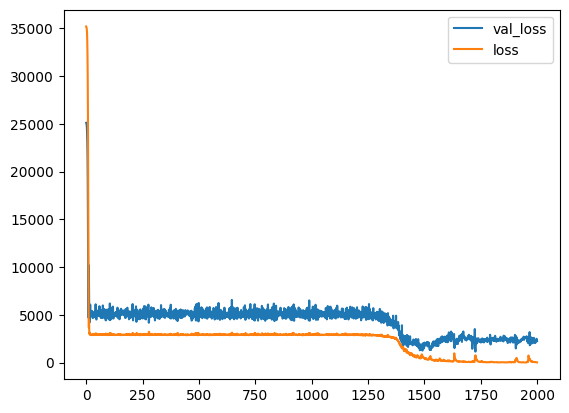

In [7]:
#画出迭代loss和acc曲线
pd.DataFrame(model.history.history).plot()

In [1]:
#在训练集上的拟合结果

y_train_predict=model.predict(X_train)
y_train_predict=y_train_predict[:,0]


plt.plot(y_train, label='True Values')
plt.plot(y_train_predict, label='Predictions')
plt.xlabel('Training Data')
plt.ylabel('Value(mm)')
plt.title('True Values vs Predictions')
plt.legend()
plt.show()

'''
draw=pd.concat([pd.DataFrame(y_train),pd.DataFrame(y_train_predict)],axis=1)
draw.iloc[100:150,0].plot(figsize=(12,6))
draw.iloc[100:150,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),fontsize='15')
plt.title("Training Data",fontsize='30') #添加标题
#plt.show()
#fig.savefig('./LSTM model performance/Regression_heel_test/train_Validation_loss.png')
#展示在训练集上的表现 
'''
'''
epocha=range(len(y_train))
epochb=range(len(y_train_predict))
plt.plot(epocha, y_train, 'g', label='real')
plt.plot(epochb, y_train_predict, 'b', label='predict')
plt.legend(('real', 'predict'),fontsize='15')
plt.title("Train Data",fontsize='30') #添加标题
plt.show()
'''

NameError: name 'model' is not defined

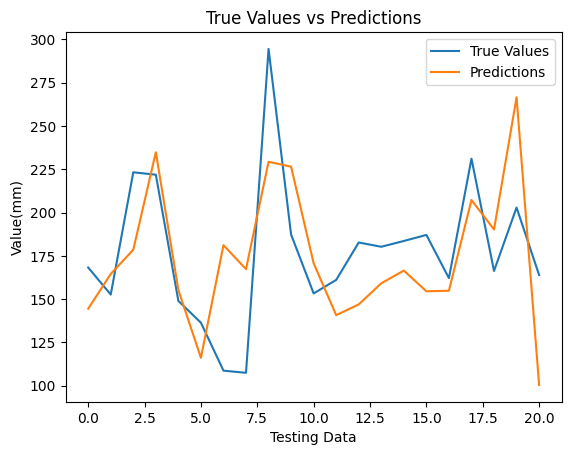

'\nepochc=range(len(y_test))\nepochd=range(len(y_test_predict))\n\nplt.plot(epochc, y_test, \'g\', label=\'real\')\nplt.plot(epochd, y_test_predict, \'b\', label=\'predict\')\nplt.title("Test Data",fontsize=\'30\') #添加标题\nplt.legend((\'real\', \'predict\'),loc=\'upper right\',fontsize=\'15\')\nplt.show()\n'

In [9]:
y_test_predict=model.predict(X_test)
y_test_predict=y_test_predict[:,0]
# Plot the true values and predictions
plt.plot(y_test, label='True Values')
plt.plot(y_test_predict, label='Predictions')
plt.xlabel('Testing Data')
plt.ylabel('Value(mm)')
plt.title('True Values vs Predictions')
plt.legend()
plt.show()


'''
#在测试集上的预测
y_test_predict=model.predict(X_test)
y_test_predict=y_test_predict[:,0]
draw=pd.concat([pd.DataFrame(y_test),pd.DataFrame(y_test_predict)],axis=1);
draw.iloc[200:250,0].plot(figsize=(12,6))
draw.iloc[200:250,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
plt.title("Test Data",fontsize='30') #添加标题
#展示在测试集上的表现 

y_test_predict = model.predict(X_test).flatten()
y_test_predict=y_test_predict[:,0]
a = plt.axes(aspect='equal')
plt.scatter(y_test, y_test_predict)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 100]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
'''
'''
epochc=range(len(y_test))
epochd=range(len(y_test_predict))

plt.plot(epochc, y_test, 'g', label='real')
plt.plot(epochd, y_test_predict, 'b', label='predict')
plt.title("Test Data",fontsize='30') #添加标题
plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
plt.show()
'''

In [10]:
#輸出结果
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
print('訓練集上的MAE/MSE/MAPE')
print(mean_absolute_error(y_train_predict, y_train))
print(mean_squared_error(y_train_predict, y_train) )
print(mape(y_train_predict, y_train) )
print('測試集上的MAE/MSE/MAPE')
print(mean_absolute_error(y_test_predict, y_test))
print(mean_squared_error(y_test_predict, y_test) )
print(mape(y_test_predict,  y_test) )
y_var_test=y_test[1:]-y_test[:len(y_test)-1]
y_var_predict=y_test_predict[1:]-y_test_predict[:len(y_test_predict)-1]
txt=np.zeros(len(y_var_test))
for i in range(len(y_var_test-1)):
    txt[i]=np.sign(y_var_test[i])==np.sign(y_var_predict[i])
result=sum(txt)/len(txt)
print('預測漲跌正確:',result)
print('Training Model took: ', fitting_model_time - start_fitting)
#print('训练时间（秒）:',54.56)

end = time.time()
print('TOTAL time spent', end-start)

訓練集上的MAE/MSE/MAPE
4.233958471141748
38.67353497459289
2.616606989869932
測試集上的MAE/MSE/MAPE
32.53770780442721
1477.621822486476
19.37228165886674
預測漲跌正確: 0.65
Training Model took:  402.879088640213
TOTAL time spent 701.3327374458313
